(heat-pump-label)=

# Heat Pump

## Introduction

```{figure} /figures/heat_pump.svg
---
name: heat-pump-flowsheet
---
Flow sheet of the simplest implementation of a heat pump.
```

As the final simple thermodynamic cycle, a heat pump will be subject of the exergy analysis. Heat pumps are a promising technology in the process of climate change mitigation, because they can replace conventional fossil fuel based heating plants. As heat pumps are scalable, they can be used in households and building, as well as whole neighbourhoods and in district heating systems. A heat pump employs the well known refrigeration cycle (see {numref}`heat-pump-flowsheet`), but instead uses the heat that is transfered out of the system. For the cycle to work, heat has to be transferred into the system at a lower temperature level and through the input of work can be transferred out on a higher temperature level. The resulting energy balance of a heat pump is displayed in Eq. {eq}`heat-pump-energy-balance`.

```{math}
    :label: heat-pump-energy-balance
    0 = Q_{in} + Q_{out} + W_{in}
```

As traditionally is done with heat engines, the benefit of a cycle can be put in to relation with the necessary input. Formalizing this expression yields the so called coefficient of performance of a heat pump, as is shown in Eq. {eq}`heat-pump-coefficient-of-performance`. From the energy balance {eq}`heat-pump-energy-balance` we can infer, that the outgoing heat is the sum of the work and heat put in. This means, that the $COP$ must be greater than {math}`1`, in contrast to the thermal efficiency of heat engines.

```{math}
    :label: heat-pump-coefficient-of-performance
    COP = \frac{Q_{out}}{W_{in}}
```

Coming from thermal efficiencies of heat engines, this can seem to be in conflict the laws of thermodynamics. We get more heat from the cycle than work needs to be put in. There only has to be an ambient heat source supply heat at a lower temperature. To reveal the thermodynamic losses occuring in this process and to show that the cycle is no perpetuum mobile, we can analyze the exergy flows.

At first, we have to define the fuel and the product of the heat pump cycle. As described above, the benefit of the cycle is the heat transfered out of the system, which makes it the product. The necessary fuels logically are the heat and work inputs. Added to the compressor work are necessary supplemental work inputs like recirculation pumps. With these defined, we can start to build the heat pump model.

## Exercise 1

1. Build a simple heat pump model using ammonia with TESPy according to the flowsheet in {numref}`heat-pump-flowsheet`, but add a water fed heat source (the hot side of the evaporator) and a consumer cycle as the heat sink (the cold side of the condenser). Parametrize the model according to the description as shown in {numref}`heat-pump-param`.
2. Execute the exergy analysis for the heat pump model. Visualize how each component destroyes part of the fuel exergy through a waterfall diagram. Analyze the influence of the compressors isentropic efficiency, as well as that of the heat exchangers terminal temperature differences.
3. Analyze the impact of the ambient temperature level on the components and total efficiency.

```{list-table} Parametrization of the heat pump
:header-rows: 1
:name: heat-pump-param

* - Description
  - Parameter
  - Value
  - Unit
* - Compressor
  - Isentropic efficiency
  - 75
  - \%
* - 
  - Motor efficiency
  - 96
  - \%
* - Pumps
  - Isentropic efficiency
  - 80
  - \%
* - 
  - Motor efficiency
  - 96
  - \%
* - All Heat Exchangers
  - Pressure losses
  - 2
  - \%
* - 
  - Terminal temperature difference
  - 2
  - K
* - Heat Sink
  - Nominal heat demand
  - -500
  - kW
* - 
  - Feed flow temperature
  - 70
  - °C
* - 
  - Back flow temperature
  - 50
  - °C
* - 
  - System pressure
  - 10
  - bar
* - Heat Source
  - Incoming temperature
  - 10
  - °C
* - 
  - Temperature reduction
  - 5
  - K
* - 
  - System pressure
  - 1.013
  - bar
```

```{note}

If you are heaving trouble with the simulation not converging, try setting best guesses for pressures instead of terminal temperature differences and only after a succesful simulation reset the intended values (see also the TESPy tutorial on 
<a href="https://tespy.readthedocs.io/en/dev/tutorials/starting_values.html#tespy-tutorial-starting-values-label">How to Generate Stable Starting Values</a>).
```

```{note}

If you are encountering problems with specific components during the exergy analysis, try having a look at the individual components <a href="https://tespy.readthedocs.io/en/latest/api.html">API documentation</a> and their respective implementation of the `exergy_balance` method.
```

### Proposed solution 1.1

**First step:** Build the heat pump model topology

In [40]:
from tespy.networks import Network
from tespy.connections import Connection, Bus
from tespy.components import (
    CycleCloser, Source, Sink, Pump, HeatExchanger, Condenser,
    HeatExchangerSimple, Compressor, Valve
    )

# Network
refrigerant = 'Ammonia'
nw = Network(
    fluids=[refrigerant, 'water'],
    T_unit='C', p_unit='bar', h_unit='kJ / kg', m_unit='kg / s'
)

# Components
cycle_closer = CycleCloser('Refrigerant Cycle Closer')

heatsource_ff = Source('Heat Source Feed Flow')
evaporator = HeatExchanger('Evaporator')
heatsource_pump = Pump('Heat Source Recirculation Pump')
heatsource_bf = Sink('Heat Source Back Flow')

compressor = Compressor('Compressor')

cons_cc = CycleCloser('Consumer Cycle Closer')
cons_pump = Pump('Heat Sink Recirculation Pump')
condenser = Condenser('Condenser')
cons_heatsink = HeatExchangerSimple('Heat Consumer')

valve = Valve('Expansion Valve')

# Connections
cc2evap = Connection(cycle_closer, 'out1', evaporator, 'in2', label='00')
hs_ff2evap = Connection(heatsource_ff, 'out1', evaporator, 'in1', label='10')
evap2hs_pump = Connection(evaporator, 'out1', heatsource_pump, 'in1', label='11')
hs_pump2hs_bf = Connection(heatsource_pump, 'out1', heatsource_bf, 'in1', label='12')

nw.add_conns(cc2evap, hs_ff2evap, evap2hs_pump, hs_pump2hs_bf)

evap2comp = Connection(evaporator, 'out2', compressor, 'in1', label='01')
comp2cond = Connection(compressor, 'out1', condenser, 'in1', label='02')

nw.add_conns(evap2comp, comp2cond)

cons_cc2cons_pump = Connection(cons_cc, 'out1', cons_pump, 'in1', label='20')
cons_pump2cond = Connection(cons_pump, 'out1', condenser, 'in2', label='21')
cond2cons_hs = Connection(condenser, 'out2', cons_heatsink, 'in1', label='22')
cons_hs2cons_cc = Connection(cons_heatsink, 'out1', cons_cc, 'in1', label='23')

nw.add_conns(cons_cc2cons_pump, cons_pump2cond, cond2cons_hs, cons_hs2cons_cc)

cond2valve = Connection(condenser, 'out1', valve, 'in1', label='03')
valve2cc = Connection(valve, 'out1', cycle_closer, 'in1', label='04')

nw.add_conns(cond2valve, valve2cc)



**Second step:** Set the heat pumps process parameters and starting values and define the energy busses

In [41]:
from CoolProp.CoolProp import PropsSI as PSI

# Component parameters
compressor.set_attr(eta_s=0.75)
cons_pump.set_attr(eta_s=0.8)
heatsource_pump.set_attr(eta_s=0.8)

evaporator.set_attr(pr1=0.98, pr2=0.98)
condenser.set_attr(pr1=0.98, pr2=0.98)
cons_heatsink.set_attr(pr=0.98, Q=-500e3, dissipative=False)

# Connection parameters
cond2cons_hs.set_attr(T=70, p=10, fluid={refrigerant: 0, 'water': 1})
cons_hs2cons_cc.set_attr(T=50)

hs_ff2evap.set_attr(T=10, p=1.013, fluid={refrigerant: 0, 'water': 1})
evap2hs_pump.set_attr(T=5)
hs_pump2hs_bf.set_attr(p=1.013)

evap2comp.set_attr(x=1, fluid={refrigerant: 1, 'water': 0})

# Starting values
p_evap = PSI('P', 'Q', 1, 'T', 5 - 2 + 273.15, refrigerant)
evap2comp.set_attr(p=p_evap*1e-5)
p_cond = PSI('P', 'Q', 0, 'T', 70 + 2 + 273.15, refrigerant)
cond2valve.set_attr(p=p_cond*1e-5)

# Busses
heat_in = Bus('Heat Input')
heat_in.add_comps(
    {'comp': heatsource_ff, 'base': 'bus'},
    {'comp': heatsource_bf, 'base': 'component'}
    )

heat_out = Bus('Heat Output')
heat_out.add_comps(
    {'comp': cons_heatsink, 'base': 'component'})

power_in = Bus('Power Input')
power_in.add_comps(
    {'comp': compressor, 'char': 0.96, 'base': 'bus'},
    {'comp': heatsource_pump, 'char': 0.96, 'base': 'bus'},
    {'comp': cons_pump, 'char': 0.96, 'base': 'bus'}
    )

nw.add_busses(heat_in, heat_out, power_in)


**Third step:** Solve model with starting and final values

In [42]:
from tespy.tools import ExergyAnalysis

# Initial solve with starting values
nw.set_attr(iterinfo=False)
nw.solve('design')

# Final solve 
evap2comp.set_attr(p=None)
cond2valve.set_attr(p=None)
evaporator.set_attr(ttd_l=2)
condenser.set_attr(ttd_u=2)

nw.solve('design')
print(f'COP = {abs(heat_out.P.val)/power_in.P.val:.3f}')


COP = 3.060


### Proposed solution 1.2

**First step:** Create and execute `ExergyAnalysis` instance and prepare result data

In [43]:
from tespy.tools import ExergyAnalysis

ean = ExergyAnalysis(network=nw, E_F=[heat_in, power_in], E_P=[heat_out])
ean.analyse(pamb=1.013, Tamb=25)
ean.print_results(groups=False, connections=False, aggregation=False)

comps = ['Fuel Exergy']
E_F = ean.network_data.E_F
E_D = [0]
E_P = [E_F]
for comp in ean.aggregation_data.index:
    # only plot components with exergy destruction > 1 W
    if ean.aggregation_data.E_D[comp] > 1 :
        comps.append(comp)
        E_D.append(ean.aggregation_data.E_D[comp])
        E_F = E_F - ean.aggregation_data.E_D[comp]
        E_P.append(E_F)
comps.append('Product Exergy')
E_D.append(0)
E_P.append(E_F)

E_D = [E * 1e-3 for E in E_D]
E_P = [E * 1e-3 for E in E_P]


##### RESULTS: Component exergy analysis #####
+--------------------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|                                |         E_F |         E_P |         E_D |     epsilon |        y_Dk |       y*_Dk |
|--------------------------------+-------------+-------------+-------------+-------------+-------------+-------------|
| Condenser                      |   8.577e+04 |   5.238e+04 |   3.339e+04 |   6.107e-01 |   2.351e-01 |   3.725e-01 |
| Compressor                     |   1.574e+05 |   1.316e+05 |   2.585e+04 |   8.358e-01 |   1.820e-01 |   2.884e-01 |
| Expansion Valve                |   4.488e+04 |   2.820e+04 |   1.668e+04 |   6.284e-01 |   1.174e-01 |   1.861e-01 |
| Evaporator                     |   2.840e+04 |   2.141e+04 |   6.989e+03 |   7.539e-01 |   4.921e-02 |   7.798e-02 |
| Heat Consumer                  |   5.251e+04 |   5.239e+04 |   1.198e+02 |   9.977e-01 |   8.436e-04 |   1.337e-03 |
|

**Second step:** Plot the waterfall diagram of the heat pump process

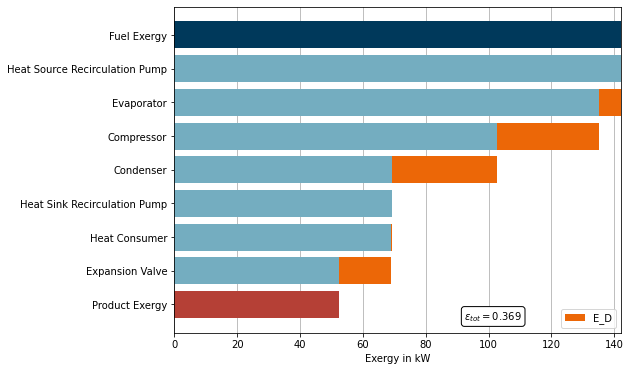

In [44]:
import matplotlib.pyplot as plt
import numpy as np

colors_E_P = ['#74ADC0'] * len(comps)
colors_E_P[0] = '#00395B'
colors_E_P[-1] = '#B54036'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(comps)), E_P, align='center', color=colors_E_P)
ax.barh(np.arange(len(comps)), E_D, align='center', left=E_P, label='E_D', color='#EC6707')

ax.legend()
ax.annotate(
    f'$\epsilon_{{tot}} = ${E_P[-1]/E_P[0]:.3f}', (0.65, 0.05),
    xycoords='axes fraction',
    ha='left', va='center', color='k',
    bbox=dict(boxstyle='round,pad=0.3', fc='white')
    )
ax.set_xlabel('Exergy in kW')
ax.set_yticks(np.arange(len(comps)))
ax.set_yticklabels(comps)
ax.invert_yaxis()
ax.grid(axis='x')
ax.set_axisbelow(True)

**Third step:** Variate compressor isentropic efficiency and terminal temperature differences of evaporator and condenser

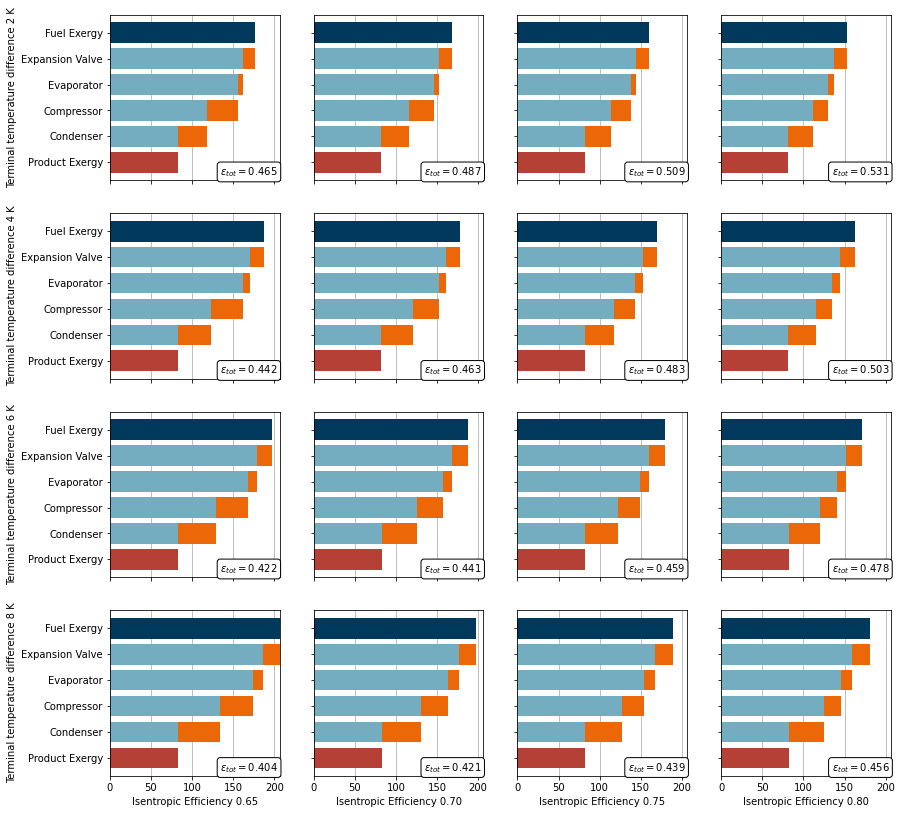

In [37]:
def get_ean_results(ean, comps):
    E_F = ean.network_data.E_F * 1e-3
    E_D = [0]
    E_P = [E_F]

    for comp in comps[1:-1]:
        E_D += [ean.aggregation_data.E_D[comp] * 1e-3]
        E_F -= E_D[-1]
        E_P += [E_F]

    E_D += [0]
    E_P += [E_F]

    return E_P, E_D

eta_s_range = np.linspace(0.65, 0.8, 4)
ttd_range = np.arange(2, 10, 2)
comps = [
    'Fuel Exergy', 'Expansion Valve', 'Evaporator', 'Compressor', 'Condenser',
    'Product Exergy'
    ]

fig, axs = plt.subplots(
    len(ttd_range), len(eta_s_range),
    sharex=True, sharey=True, figsize=(14, 14)
    )
axs[0, 0].invert_yaxis()

for col, eta_s in enumerate(eta_s_range):
    compressor.set_attr(eta_s=eta_s)
    for row, ttd in enumerate(ttd_range):
        evaporator.set_attr(ttd_l=ttd)
        condenser.set_attr(ttd_u=ttd)

        nw.solve('design')
        ean = ExergyAnalysis(network=nw, E_F=[heat_in, power_in], E_P=[heat_out])
        ean.analyse(pamb=1.013, Tamb=25)

        E_P, E_D = get_ean_results(ean, comps)

        colors_E_P = ['#74ADC0'] * len(comps)
        colors_E_P[0] = '#00395B'
        colors_E_P[-1] = '#B54036'

        axs[row, col].barh(
            np.arange(len(comps)), E_P, align='center', color=colors_E_P
            )
        axs[row, col].barh(
            np.arange(len(comps)), E_D, align='center', left=E_P, label='E_D', color='#EC6707'
            )

        axs[row, col].set_yticks(np.arange(len(comps)))
        axs[row, col].set_yticklabels(comps)
        axs[row, col].grid(axis='x')
        axs[row, col].set_axisbelow(True)

        axs[row, col].annotate(
                    f'$\epsilon_{{tot}} = ${E_P[-1]/E_P[0]:.3f}', (0.65, 0.05),
                    xycoords='axes fraction',
                    ha='left', va='center', color='k',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white')
                    )

        if row == len(ttd_range)-1:
            axs[row, col].set_xlabel(f'Isentropic Efficiency {eta_s:.2f}')
        if col == 0:
            axs[row, col].set_ylabel(f'Terminal temperature difference {ttd} K')

## Process optimization

There are many ways to improve a heat pumps $COP$ by changing the process through the addition of components. A popular topological improvement is the so called *Economizer*, where part of the condensate gets evaporated on an intermediate pressure level and injected between two compressor stages. This is done in order to yield a cooler mixture entering the high pressure compressor and to reduce the final output temperature of the superheated gas. The evaporation of part of the condensate is reached through subcooling of the rest of it via an internal heat exchanger. The topology of this improved heat pump cycle can be seen in the flowsheet depicted in <div style="color:red">Figure XX</div>.

```{figure} /figures/heat_pump_economizer.svg
---
name: heat-pump-econ-flowsheet
---
Flow sheet of a heat pump with an economizer.
```

## Exercise 2

Build the heat pump model including the economizer according to the flowsheet (see Figure XX) and the parametrization of {numref}`heat-pump-param`. Additionally you need to set ... Explain the improvement of the heat pumps $COP$ by analyzing the exergy destruction of each component.

### Proposed solution 2

**First step:** Build the extenden heat pump cycle with economizer

In [38]:
from tespy.connections import Ref
from tespy.components import Merge, Splitter

# Network
refrigerant = 'Ammonia'
nw_econ = Network(
    fluids=[refrigerant, 'water'],
    T_unit='C', p_unit='bar', h_unit='kJ / kg', m_unit='kg / s'
)

# Components
cycle_closer = CycleCloser('Refrigerant Cycle Closer')

heatsource_ff = Source('Heat Source Feed Flow')
evaporator = HeatExchanger('Evaporator')
heatsource_pump = Pump('Heat Source Recirculation Pump')
heatsource_bf = Sink('Heat Source Back Flow')

lp_compressor = Compressor('Low Pressure Compressor')
merge = Merge('Injection')
hp_compressor = Compressor('High Pressure Compressor')

cons_cc = CycleCloser('Consumer Cycle Closer')
cons_pump = Pump('Heat Sink Recirculation Pump')
condenser = Condenser('Condenser')
cons_heatsink = HeatExchangerSimple('Heat Consumer')

split = Splitter('Condensate Splitter')
intermediate_valve = Valve('Intermediate Valve')
economizer = HeatExchanger('Economizer')

valve = Valve('Main Valve')

# Connections
# cc2evap = Connection(cycle_closer, 'out1', evaporator, 'in2', label='00')
hs_ff2evap = Connection(heatsource_ff, 'out1', evaporator, 'in1', label='10')
evap2hs_pump = Connection(evaporator, 'out1', heatsource_pump, 'in1', label='11')
hs_pump2hs_bf = Connection(heatsource_pump, 'out1', heatsource_bf, 'in1', label='12')

# nw_econ.add_conns(cc2evap, hs_ff2evap, evap2hs_pump, hs_pump2hs_bf)
nw_econ.add_conns(hs_ff2evap, evap2hs_pump, hs_pump2hs_bf)

evap2lp_comp = Connection(evaporator, 'out2', lp_compressor, 'in1', label='01')
lp_comp2merge = Connection(lp_compressor, 'out1', merge, 'in1', label='02')
merge2hp_comp = Connection(merge, 'out1', hp_compressor, 'in1', label='03')
hp_comp2cond = Connection(hp_compressor, 'out1', condenser, 'in1', label='04')

nw_econ.add_conns(evap2lp_comp, lp_comp2merge, merge2hp_comp, hp_comp2cond)

cons_cc2cons_pump = Connection(cons_cc, 'out1', cons_pump, 'in1', label='20')
cons_pump2cond = Connection(cons_pump, 'out1', condenser, 'in2', label='21')
cond2cons_hs = Connection(condenser, 'out2', cons_heatsink, 'in1', label='22')
cons_hs2cons_cc = Connection(cons_heatsink, 'out1', cons_cc, 'in1', label='23')

nw_econ.add_conns(cons_cc2cons_pump, cons_pump2cond, cond2cons_hs, cons_hs2cons_cc)

cond2cc = Connection(condenser, 'out1', cycle_closer, 'in1', label='05')
cc2split = Connection(cycle_closer, 'out1', split, 'in1', label='05cc')
main_valve2evap = Connection(valve, 'out1', evaporator, 'in2', label='00')
nw_econ.add_conns(cond2cc, cc2split, main_valve2evap)

# cond2split = Connection(condenser, 'out1', split, 'in1', label='05')
split2econ = Connection(split, 'out1', economizer, 'in1', label='06')
econ2main_valve = Connection(economizer, 'out1', valve, 'in1', label='07')
split2inter_valve = Connection(split, 'out2', intermediate_valve, 'in1', label='30')
inter_valve2econ = Connection(intermediate_valve, 'out1', economizer, 'in2', label='31')
econ2merge = Connection(economizer, 'out2', merge, 'in2', label='32')
# main_valve2cc = Connection(valve, 'out1', cycle_closer, 'in1', label='08')

# nw_econ.add_conns(
#     cond2split, split2econ, econ2main_valve, split2inter_valve,
#     inter_valve2econ, econ2merge, main_valve2cc
#     )

nw_econ.add_conns(
    split2econ, econ2main_valve, split2inter_valve,
    inter_valve2econ, econ2merge
    )

# Component parameters
lp_compressor.set_attr(eta_s=0.75)
hp_compressor.set_attr(eta_s=0.75)
cons_pump.set_attr(eta_s=0.8)
heatsource_pump.set_attr(eta_s=0.8)

evaporator.set_attr(pr1=0.98, pr2=0.98)
condenser.set_attr(pr1=0.98, pr2=0.98)
economizer.set_attr(pr1=0.98, pr2=0.98)
cons_heatsink.set_attr(pr=0.98, Q=-500e3, dissipative=False)

# Connection parameters
cond2cons_hs.set_attr(T=70, p=10, fluid={refrigerant: 0, 'water': 1})
cons_hs2cons_cc.set_attr(T=50)

hs_ff2evap.set_attr(T=10, p=1.013, fluid={refrigerant: 0, 'water': 1})
evap2hs_pump.set_attr(T=5)
hs_pump2hs_bf.set_attr(p=1.013)

evap2lp_comp.set_attr(x=1) #, fluid={refrigerant: 1, 'water': 0})
cond2cc.set_attr(fluid={refrigerant: 1, 'water': 0})

split2econ.set_attr(m=Ref(hp_comp2cond, 0.85, 0))

# Starting values
p_evap = PSI('P', 'Q', 1, 'T', 5 - 2 + 273.15, refrigerant) * 1e-5
# cc2evap.set_attr(p=p_evap)
main_valve2evap.set_attr(p=p_evap)
p_cond = PSI('P', 'Q', 0, 'T', 70 + 2 + 273.15, refrigerant) * 1e-5
hp_comp2cond.set_attr(p=p_cond)
p_mid = np.sqrt(p_evap * p_cond)
econ2merge.set_attr(p=p_mid, x=1)

# Busses
heat_in = Bus('Heat Input')
heat_in.add_comps(
    {'comp': heatsource_ff, 'base': 'bus'},
    {'comp': heatsource_bf, 'base': 'component'}
    )

heat_out = Bus('Heat Output')
heat_out.add_comps(
    {'comp': cons_heatsink, 'base': 'component'})

power_in = Bus('Power Input')
power_in.add_comps(
    {'comp': lp_compressor, 'char': 0.96, 'base': 'bus'},
    {'comp': hp_compressor, 'char': 0.96, 'base': 'bus'},
    {'comp': heatsource_pump, 'char': 0.96, 'base': 'bus'},
    {'comp': cons_pump, 'char': 0.96, 'base': 'bus'}
    )

nw_econ.add_busses(heat_in, heat_out, power_in)

# # Initial solve with starting values
nw_econ.set_attr(interinfo=True)
nw_econ.solve('design')
nw_econ.print_results()

# cc2evap.set_attr(p=None)
main_valve2evap.set_attr(p=None)
evaporator.set_attr(ttd_l=2)
hp_comp2cond.set_attr(p=None)
condenser.set_attr(ttd_u=2)

# nw_econ.set_attr(interinfo=True)
nw_econ.solve('design')
nw_econ.print_results()

print(f'COP = {abs(heat_out.P.val)/power_in.P.val:.3f}')


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      |            
-------+------------+------------+------------+------------+------------+------------+
 1     | 9.13e+06   | 50 %       | 4.04e+01   | 7.52e+06   | 4.44e+06   | 1.75e-15   |            
 2     | 2.43e+07   | 50 %       | 3.60e+02   | 1.69e+06   | 1.15e+06   | 4.58e-16   |            
 3     | 4.63e+06   | 50 %       | 4.19e+02   | 2.84e+05   | 9.89e+04   | 2.20e-16   |            
 4     | 5.73e+05   | 50 %       | 2.26e+01   | 4.06e-10   | 7.85e+05   | 0.00e+00   |            
 5     | 1.80e+05   | 50 %       | 1.25e-01   | 2.40e-10   | 4.72e+05   | 9.36e-17   |            
 6     | 2.47e+04   | 50 %       | 7.58e-01   | 3.30e-10   | 3.18e+04   | 2.13e-16   |            
 7     | 3.18e+02   | 51 %       | 1.90e-02   | 2.40e-10   | 4.42e+01   | 1.09e-16   |            
 8     | 1.09e-02   | 52 %       | 5.03e-11   | 3.30e-10   | 2.91e-02   | 1.64e-16   |            
 9     | 1.20e-06   |

**Second step:** Create and execute `ExergyAnalysis` instance and prepare result data and plot the waterfall diagram of the heat pump process

In [39]:
ean_econ = ExergyAnalysis(network=nw_econ, E_F=[heat_in, power_in], E_P=[heat_out])
ean_econ.analyse(pamb=1.013, Tamb=25)
ean_econ.print_results(groups=False, connections=False, aggregation=False)

comps = [
    'Fuel Exergy', 'Economizer', 'Main Valve', 'Evaporator', 'Low Pressure Compressor', 
    'Injection', 'High Pressure Compressor', 'Condenser', 'Intermediate Valve', 
    'Product Exergy'
    ]

E_P, E_D = get_ean_results(ean_econ, comps)

colors_E_P = ['#74ADC0'] * len(comps)
colors_E_P[0] = '#00395B'
colors_E_P[-1] = '#B54036'

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(comps)), E_P, align='center', color=colors_E_P)
ax.barh(np.arange(len(comps)), E_D, align='center', left=E_P, label='E_D', color='#EC6707')

ax.legend()
ax.annotate(
    f'$\epsilon_{{tot}} = ${E_P[-1]/E_P[0]:.3f}', (0.65, 0.05),
    xycoords='axes fraction',
    ha='left', va='center', color='k',
    bbox=dict(boxstyle='round,pad=0.3', fc='white')
    )
ax.set_xlabel('Exergy in kW')
ax.set_yticks(np.arange(len(comps)))
ax.set_yticklabels(comps)
ax.invert_yaxis()
ax.grid(axis='x')
ax.set_axisbelow(True)

##### RESULTS: Component exergy analysis #####
+--------------------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|                                |         E_F |         E_P |         E_D |     epsilon |        y_Dk |       y*_Dk |
|--------------------------------+-------------+-------------+-------------+-------------+-------------+-------------|
| Condenser                      |   1.054e+05 |   7.489e+04 |   3.051e+04 |   7.105e-01 |   1.979e-01 |   3.848e-01 |
| High Pressure Compressor       |   8.977e+04 |   7.576e+04 |   1.402e+04 |   8.439e-01 |   9.090e-02 |   1.768e-01 |
| Low Pressure Compressor        |   6.099e+04 |   4.886e+04 |   1.212e+04 |   8.012e-01 |   7.863e-02 |   1.529e-01 |
| Evaporator                     |   9.718e+03 |   3.119e+03 |   6.599e+03 |   3.210e-01 |   4.280e-02 |   8.323e-02 |
| Main Valve                     |   1.383e+04 |   8.929e+03 |   4.904e+03 |   6.455e-01 |   3.181e-02 |   6.185e-02 |
|